##Class structure

In [ ]:
!pip install numpy matplotlib

In [ ]:

## Imports

import random as rd
import matplotlib.pyplot as plt
import numpy as np

## Global variables

# Number of alternatives, denoted a, b, c, ..., n respectively
M_ALTERNATIVES = 2

# Amount of evidence there is for a as well as b
A_EVIDENCE = 3
B_EVIDENCE = 2

# Global constant to adjust probability of gaining pieces of evidence
P_COMPETENCE = 0.6

## Helper functions

def first_non_zero(arr):
    for element in arr:
        if element != 0:
            return element
    return None  # If all elements are zero, return None

## Defining Classes

class DeliberationSetting:
    def __init__(self, no_of_agents=5, a_evidence=3, b_evidence=2, p_competence=0.6):
        '''if no_of_agents % 2 == 0:
            raise ValueError("Behold, number of agents must be odd!")'''

        self.number_of_agents = no_of_agents
        self.A_EVIDENCE = a_evidence
        self.B_EVIDENCE = b_evidence
        self.P_COMPETENCE = p_competence

        self.crowd = Crowd(no_of_agents=self.number_of_agents, p_competence=self.P_COMPETENCE, a_evidence=self.A_EVIDENCE, b_evidence=self.B_EVIDENCE)

    def run_sim_keen(self):
        return self.crowd.deliberate_sim()


class Agent:

    def __init__(self, p_competence=0.6, a_evidence = 3, b_evidence = 2):

        self.P_COMPETENCE = p_competence
        self.A_EVIDENCE = a_evidence
        self.B_EVIDENCE = b_evidence

        self.es_A, self.es_B = self.sample_evidence() # Takes predefined evidence sets in, TBD adjust if necessary

        # Bool arrays to indicate whether a piece of evidence was learned from others or not
        self.es_A_acquired = [0] * self.A_EVIDENCE
        self.es_B_acquired = [0] * self.B_EVIDENCE

        self.update_top_keen() # Finds top alternative based on size of respective evidence sets

    def sample_evidence(self):
        evidence_for_a = [None] * self.A_EVIDENCE
        evidence_for_b = [None] * self.B_EVIDENCE

        # Fill evidence_for_a
        for i in range(len(evidence_for_a)):
            if rd.uniform(0, 1) <= self.P_COMPETENCE:
                evidence_for_a[i] = 1
            else:
                evidence_for_a[i] = 0

        # Fill evidence_for_b
        for i in range(len(evidence_for_b)):
            if rd.uniform(0, 1) <= self.P_COMPETENCE:
                evidence_for_b[i] = 1
            else:
                evidence_for_b[i] = 0

        return evidence_for_a, evidence_for_b

    # Determines current favorite
    def update_top_keen(self):
        # Count the number of ones in each list
        count_a = self.es_A.count(1)
        count_b = self.es_B.count(1)

        # Set self.top based on which list has more ones
        if count_a > count_b:
            self.top = 'A'
        elif count_b > count_a:
            self.top = 'B'
        else:
            # Handle the undecided state when counts are equal
            #raise ValueError("Agent undecided! What to do now?")

            self.top = 'X' # Stands for indifference or equal evidence

    ''' # Learning new pieces of evidence: Increases evidence set for either option A or B
    def learn_for(self, option, evidence_index):
        if option in ['A', 'B']:
            # Construct the attribute name based on the input
            es_name = f'es_{option}'
            es_name_acquired = f'{es_name}_acquired'

            # Retrieve the attribute (list) using getattr
            attr_list = getattr(self, es_name)
            acquired_list = getattr(self, es_name_acquired)

            # Ensure the evidence index is within valid range (1-based to 0-based)
            if 1 <= evidence_index <= len(attr_list):
                zero_index = evidence_index - 1
                attr_list[zero_index] = 1  # Set the specific index to 1
                acquired_list[zero_index] = 1 # Sets acquired index for the corresponding element to 1
            else:
                print(f"Error: evidence_index {evidence_index} is out of range.")

            # Update preferred option
            self.update_top()
        else:
            # handle invalid input for A
            print(f"Invalid option: {option}. Please choose 'A' or 'B'.")'''

class Crowd: # Some sort of dynamic process tracker / protocol initally, now a collective of agents

    def __init__(self, no_of_agents=5, p_competence=0.6, a_evidence=3, b_evidence=2):

        self.A_EVIDENCE = a_evidence
        self.B_EVIDENCE = b_evidence
        self.P_COMPETENCE = p_competence

        #if no_of_agents % 2 == 1:
        self.agents = [Agent(p_competence=self.P_COMPETENCE, a_evidence=self.A_EVIDENCE, b_evidence=self.B_EVIDENCE) for _ in range(no_of_agents)]
        #else:
           # raise ValueError("Number of agents must be odd.")

        self.public_evidence_A = [0] * len(self.agents[0].es_A)
        self.public_evidence_B = [0] * len(self.agents[0].es_B)
    # In case anything goes wrong and number needs to be readjusted

    def set_no_of_agents(self, number):
        self.no_of_agents = number

    def generate_profile(self, agents):
        profile = [None] * len(agents)

        # For each agent, call their top-ranked alternative and save it in a index-corresponding array
        for i in range(len(agents)):
            profile[i] = getattr(agents[i], 'top')

        return profile


    def get_winner(self, profile):
        profile = profile

        count_a = 0
        count_b = 0

        # Iterate over the array to count occurrences
        for char in profile:

            if char == 'A':
                count_a += 1

            elif char == 'B':
                count_b += 1

            # ! In case of indifference: Do nothing
            elif char == 'X':
                continue
            else:
                raise ValueError("Input array should only contain 'A' and 'B'.")

        # Compare counts to determine which letter is more frequent
        if count_a > count_b:
            return 'A'
        elif count_b > count_a:
            return 'B'
        else:
            print("Tie! Adjust number of agents using set_no_of_agents.")
            return 'X'

    # TBD: might be able to use this method for lazy dissenters as well and only ajust the update_top function of the agents
    def dissenters_keen(self, profile):
        profile = profile
        winner = self.get_winner(profile) # This may be dangerous to do? Maybe control this variable outside the method.

        # Initialize boolean array to indicate whether agent dissents or not
        dissent = [None] * len(profile)

        i = 0
        while i < len(profile):
            if profile[i] != winner: # This works for keen dissenters, since 'X' is not 'A', so this loop would activate for indifference
                # Handling the special case of an indifferent agent
                if profile[i] == 'X':
                    dissent[i] = 'B' if winner == 'A' else 'A'
                    # We dont need to handle case 'X' here, since then the bigger encasing if clause would not be true since X = X.
                else:
                    dissent[i] = profile[i]
            i += 1

        return dissent

    # Terminal plotter for evidence distribution
    def plot_agent_evidence(self, agents):
         # Marker for each agent
         i = 1
         for agent in agents:
            print(i)
            i += 1

            es_A_own = 0
            es_B_own = 0

            # Count private evidence, which is in the evidence set but not in the acquired set
            for j in range(len(agent.es_A)):
                if agent.es_A[j] == 1 and agent.es_A_acquired[j] == 0:
                    es_A_own += 1

            for k in range(len(agent.es_B)):
                if agent.es_B[k] == 1 and agent.es_B_acquired[k] == 0:
                    es_B_own += 1

            # Distinugish between private and acquired evidence
            print("Evidence A: " + "█" * es_A_own + "▒" * agent.es_A_acquired.count(1))
            print("Evidence B: " + "█" * es_B_own + "▒" * agent.es_B_acquired.count(1))

    def deliberate_sim(self):

        # Counts how many round of deliberation we have
        round = 0

        # Return reason for return statement
        ret_reason = None

        # Intialize important variables
        profile = self.generate_profile(self.agents)
        print(profile) # ___Printer___
        majority = self.get_winner(profile)
        minority = 'A' if majority == 'B' else 'B'
        revealed_in_round_A = [0] * self.A_EVIDENCE
        revealed_in_round_B = [0] * self.B_EVIDENCE

        # Initialize dissenters
        dissenters = self.dissenters_keen(profile)
        print('First dissenters:', dissenters)

        print('First majority vote:', majority) # ____Printer____
        print()

        while dissenters != [None] * len(self.agents):

            # Start of a new round
            round += 1

            # Revelation marker: If there exists a piece of evidence that was revealed during a round, it is true. Otherwise, deliberation terminates.
            new_evidence_revealed = False

            # For all dissenters, add their evidence for the minority alternative into the revealed evidence sets

            for i, is_dissenter_letter in enumerate(dissenters):
                if is_dissenter_letter != None:
                    # Get the set of evidence for the minority option from each dissenter
                    dissenter_evidence = f'es_{is_dissenter_letter}'
                    dissenter_evidence = getattr(self.agents[i], dissenter_evidence)
                    print(f'Agent {i} s dissenter_evidence for the minority {is_dissenter_letter}: ', dissenter_evidence) # ___Printer___

                    # Update the revealed_in_round sets to take on the the revealed evidence (only one if-clause will be activated)
                    if is_dissenter_letter == 'A':
                        for j in range(len(dissenter_evidence)):
                            if dissenter_evidence[j] == 1 and revealed_in_round_A[j] != 1:
                                revealed_in_round_A[j] = 1
                                new_evidence_revealed = True # Sets revealed marker to true

                                print(f'Revealing new evidence {j} for minority option {minority} from agent {i}') # ___Printer___
                    if is_dissenter_letter == 'B':
                        for k in range(len(dissenter_evidence)):
                            if dissenter_evidence[k] == 1 and revealed_in_round_B[k] != 1:
                                revealed_in_round_B[k] = 1
                                new_evidence_revealed = True # Sets revealed marker to true

                                print(f'Revealing new evidence {k} for minority option {minority} from agent {i}') # ___Printer___

            # If no new evidence was revealed, break the loop
            if not new_evidence_revealed:
                ret_reason = 'No more evidence to reveal from dissenters.'
                break

            # Add all the evidence to the public evidence sets for A and B cumulatively
            for i in range(len(revealed_in_round_A)):
                if revealed_in_round_A[i] == 1:
                    self.public_evidence_A[i] = 1

            for i in range(len(revealed_in_round_B)):
                if revealed_in_round_B[i] == 1:
                    self.public_evidence_B[i] = 1

            # Update the indivdual evidence sets of agents to take on the revealed evidence
            for agent in self.agents:

                # Update evidence for A with public evidence
                for i in range(len(self.public_evidence_A)):
                    if self.public_evidence_A[i] == 1 and agent.es_A[i] != 1:
                        agent.es_A[i] = 1
                        agent.es_A_acquired[i] = 1 # Mark as acquired information

                # Update evidence for B with public evidence
                for i in range(len(self.public_evidence_B)):
                    if self.public_evidence_B[i] == 1 and agent.es_B[i] != 1:
                        agent.es_B[i] = 1
                        agent.es_B_acquired[i] = 1 # Mark as acquired information

                agent.update_top_keen()  # Update each agents favorite option

            # Update profile, majority and minority
            self.profile = self.generate_profile(self.agents)
            print('New profile: ', self.profile) # ___Printer___

            majority = self.get_winner(self.profile)
            print('Newly assigned majority: ', majority) #___Printer___

            minority = 'A' if majority == 'B' else 'B'
            print('Newly assgined minority: ', minority) #___Printer___

            # Update dissenters
            dissenters = self.dissenters_keen(self.profile)
            print("Dissenters: ", dissenters) # ___Printer___

        print('Generating plot for deliberation end result...')
        self.plot_agent_evidence(self.agents)

        print(f'_______________WINNER {self.get_winner(self.generate_profile(self.agents))}.______________')
        print(f'Termination at round {round}: No more dissenters.' if ret_reason == None else f'Termination at round {round}: {ret_reason}')
        return self.get_winner(self.generate_profile(self.agents))


# Running the simulations

test_crowd = Crowd()

test_crowd.deliberate_sim()










['A', 'A', 'A', 'A', 'B']
First dissenters: [None, None, None, None, 'B']
First majority vote: A

Agent 4 s dissenter_evidence for the minority B:  [1, 1]
Revealing new evidence 0 for minority option B from agent 4
Revealing new evidence 1 for minority option B from agent 4
New profile:  ['A', 'B', 'B', 'A', 'B']
Newly assigned majority:  B
Newly assgined minority:  A
Dissenters:  ['A', None, None, 'A', None]
Agent 0 s dissenter_evidence for the minority A:  [1, 1, 1]
Revealing new evidence 0 for minority option A from agent 0
Revealing new evidence 1 for minority option A from agent 0
Revealing new evidence 2 for minority option A from agent 0
Agent 3 s dissenter_evidence for the minority A:  [1, 1, 1]
New profile:  ['A', 'A', 'A', 'A', 'A']
Newly assigned majority:  A
Newly assgined minority:  B
Dissenters:  [None, None, None, None, None]
Generating plot for deliberation end result...
1
Evidence A: ███
Evidence B: █▒
2
Evidence A: █▒▒
Evidence B: ▒▒
3
Evidence A: █▒▒
Evidence B: ▒▒
4

'A'

In [ ]:
i = 100
results = []

while i != 0:
    setting = DeliberationSetting(a_evidence=9, b_evidence = 7, p_competence=0.3)
    deliberation_result = setting.run_sim_keen()
    results.append(deliberation_result)
    i -= 1


print('--------')
print('FINAL Result: ',results)

['A', 'A', 'A', 'A', 'B']
First dissenters: [None, None, None, None, 'B']
First majority vote: A

Agent 4 s dissenter_evidence for the minority B:  [1, 1, 0, 0, 0, 1, 0]
Revealing new evidence 0 for minority option B from agent 4
Revealing new evidence 1 for minority option B from agent 4
Revealing new evidence 5 for minority option B from agent 4
New profile:  ['X', 'X', 'B', 'A', 'B']
Newly assigned majority:  B
Newly assgined minority:  A
Dissenters:  ['A', 'A', None, 'A', None]
Agent 0 s dissenter_evidence for the minority A:  [0, 0, 0, 1, 0, 1, 0, 0, 1]
Revealing new evidence 3 for minority option A from agent 0
Revealing new evidence 5 for minority option A from agent 0
Revealing new evidence 8 for minority option A from agent 0
Agent 1 s dissenter_evidence for the minority A:  [1, 0, 0, 0, 1, 1, 0, 0, 0]
Revealing new evidence 0 for minority option A from agent 1
Revealing new evidence 4 for minority option A from agent 1
Agent 3 s dissenter_evidence for the minority A:  [1, 0, 

Streaming output truncated to the last 5000 lines.
Evidence A: █████▒
Evidence B: ▒▒▒▒▒
10
Evidence A: ████▒▒
Evidence B: █████
11
Evidence A: ███▒▒▒
Evidence B: ████▒
12
Evidence A: ██▒▒▒▒
Evidence B: ██▒▒▒
13
Evidence A: ██▒▒▒▒
Evidence B: ███▒▒
14
Evidence A: ██▒▒▒▒
Evidence B: █████
15
Evidence A: █████▒
Evidence B: ███▒▒
16
Evidence A: █████▒
Evidence B: █▒▒▒▒
17
Evidence A: ███▒▒▒
Evidence B: ██▒▒▒
18
Evidence A: ████▒▒
Evidence B: ███▒▒
19
Evidence A: ██▒▒▒▒
Evidence B: ███▒▒
20
Evidence A: ████▒▒
Evidence B: ████▒
21
Evidence A: ████▒▒
Evidence B: ██▒▒▒
22
Evidence A: ██▒▒▒▒
Evidence B: ████▒
23
Evidence A: ████▒▒
Evidence B: ███▒▒
24
Evidence A: ████▒▒
Evidence B: ██▒▒▒
25
Evidence A: ████▒▒
Evidence B: ███▒▒
26
Evidence A: ████▒▒
Evidence B: ██▒▒▒
27
Evidence A: ████▒▒
Evidence B: ████▒
28
Evidence A: ████▒▒
Evidence B: █▒▒▒▒
29
Evidence A: █▒▒▒▒▒
Evidence B: ██▒▒▒
30
Evidence A: ███▒▒▒
Evidence B: █████
_______________WINNER A.______________
Termination at round 2: No more d

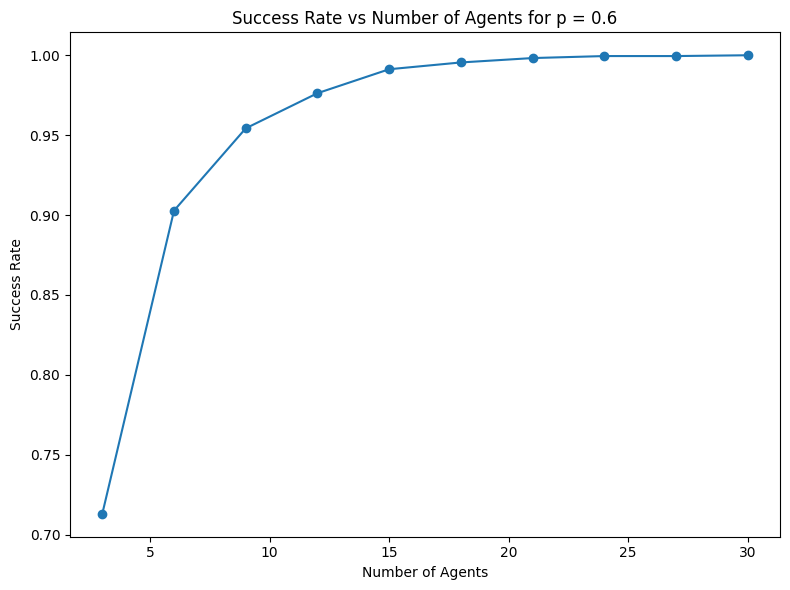

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

iterations_per_agent = 4000
competence = 0.6
agent_counts = [3,6,9,12,15,18,21,24,27,30]  # Number of agents from 2 to 10

# Array with values showing success rate corresponding to number of agents
success_rates = []

for agents in agent_counts:
    single_round_successes = []
    ties = 0


    j = 0
    # Run specified number of times
    while j < iterations_per_agent:

        deliberation_setting = DeliberationSetting(p_competence = 0.6, a_evidence=6, b_evidence=5, no_of_agents=agents)
        result = deliberation_setting.run_sim_keen()

        if result is not None:
            single_round_successes.append(result)
            j += 1
        else:
            single_round_successes.append(result)
            j +=1

    # Calculate relative success
    success_rate = single_round_successes.count('A') / iterations_per_agent
    success_rates.append(success_rate)

# Generate the new plot with number of agents vs success rate
plt.figure(figsize=(8, 6))

plt.title("Success Rate vs Number of Agents for p = 0.6")
plt.xlabel("Number of Agents")
plt.ylabel("Success Rate")
plt.plot(agent_counts, success_rates, marker='o')

plt.tight_layout()
plt.show()


## Majority bias section

In [ ]:
# Returns vote record instead of final majority vote

class CrowdWithVoteRecord(Crowd):
    def deliberate_sim(self):

        # Counts how many round of deliberation we have
        round = 0
        vote_record = []

        # Return reason for return statement
        ret_reason = None

        # Intialize important variables
        profile = self.generate_profile(self.agents)
        print(profile) # ___Printer___
        majority = self.get_winner(profile)
        minority = 'A' if majority == 'B' else 'B'
        revealed_in_round_A = [0] * self.A_EVIDENCE
        revealed_in_round_B = [0] * self.B_EVIDENCE

        vote_record.append(profile.count('A'))

        # Initialize dissenters
        dissenters = self.dissenters_keen(profile)
        print('First dissenters:', dissenters)

        print('First majority vote:', majority) # ____Printer____
        print()

        while dissenters != [None] * len(self.agents):

            # Start of a new round
            round += 1

            # Revelation marker: If there exists a piece of evidence that was revealed during a round, it is true. Otherwise, deliberation terminates.
            new_evidence_revealed = False

            # For all dissenters, add their evidence for the minority alternative into the revealed evidence sets

            for i, is_dissenter_letter in enumerate(dissenters):
                if is_dissenter_letter != None:
                    # Get the set of evidence for the minority option from each dissenter
                    dissenter_evidence = f'es_{is_dissenter_letter}'
                    dissenter_evidence = getattr(self.agents[i], dissenter_evidence)
                    print(f'Agent {i} s dissenter_evidence for the minority {is_dissenter_letter}: ', dissenter_evidence) # ___Printer___

                    # Update the revealed_in_round sets to take on the the revealed evidence (only one if-clause will be activated)
                    if is_dissenter_letter == 'A':
                        for j in range(len(dissenter_evidence)):
                            if dissenter_evidence[j] == 1 and revealed_in_round_A[j] != 1:
                                revealed_in_round_A[j] = 1
                                new_evidence_revealed = True # Sets revealed marker to true

                                print(f'Revealing new evidence {j} for minority option {minority} from agent {i}') # ___Printer___
                    if is_dissenter_letter == 'B':
                        for k in range(len(dissenter_evidence)):
                            if dissenter_evidence[k] == 1 and revealed_in_round_B[k] != 1:
                                revealed_in_round_B[k] = 1
                                new_evidence_revealed = True # Sets revealed marker to true

                                print(f'Revealing new evidence {k} for minority option {minority} from agent {i}') # ___Printer___

            # If no new evidence was revealed, break the loop
            if not new_evidence_revealed:
                ret_reason = 'No more evidence to reveal from dissenters.'
                break

            # Add all the evidence to the public evidence sets for A and B cumulatively
            for i in range(len(revealed_in_round_A)):
                if revealed_in_round_A[i] == 1:
                    self.public_evidence_A[i] = 1

            for i in range(len(revealed_in_round_B)):
                if revealed_in_round_B[i] == 1:
                    self.public_evidence_B[i] = 1

            # Update the indivdual evidence sets of agents to take on the revealed evidence
            for agent in self.agents:

                # Update evidence for A with public evidence
                for i in range(len(self.public_evidence_A)):
                    if self.public_evidence_A[i] == 1 and agent.es_A[i] != 1:
                        agent.es_A[i] = 1
                        agent.es_A_acquired[i] = 1 # Mark as acquired information

                # Update evidence for B with public evidence
                for i in range(len(self.public_evidence_B)):
                    if self.public_evidence_B[i] == 1 and agent.es_B[i] != 1:
                        agent.es_B[i] = 1
                        agent.es_B_acquired[i] = 1 # Mark as acquired information

                agent.update_top_keen()  # Update each agents favorite option

            # Update profile, majority and minority
            self.profile = self.generate_profile(self.agents)
            print('New profile: ', self.profile) # ___Printer___

            majority = self.get_winner(self.profile)
            print('Newly assigned majority: ', majority) #___Printer___

            vote_record.append(self.profile.count('A'))

            minority = 'A' if majority == 'B' else 'B'
            print('Newly assgined minority: ', minority) #___Printer___

            # Update dissenters
            dissenters = self.dissenters_keen(self.profile)
            print("Dissenters: ", dissenters) # ___Printer___

        print('Generating plot for deliberation end result...')
        self.plot_agent_evidence(self.agents)

        print(f'_______________WINNER {self.get_winner(self.generate_profile(self.agents))}.______________')
        print(f'Termination at round {round}: No more dissenters.' if ret_reason == None else f'Termination at round {round}: {ret_reason}')
        return self.get_winner(self.generate_profile(self.agents)), vote_record



In [ ]:
# For each round of deliberation that the crowd does, save the number of a_voters

crowd_deliberations = []
final_votes = []
for _ in range(40):
  crowd_special = CrowdWithVoteRecord(no_of_agents=5, p_competence=0.6, a_evidence=300, b_evidence=299)
  final_vote, process = crowd_special.deliberate_sim()
  crowd_deliberations.append(process)
  final_votes.append(final_vote)


Streaming output truncated to the last 5000 lines.
Revealing new evidence 242 for minority option A from agent 3
Revealing new evidence 243 for minority option A from agent 3
Revealing new evidence 244 for minority option A from agent 3
Revealing new evidence 245 for minority option A from agent 3
Revealing new evidence 246 for minority option A from agent 3
Revealing new evidence 247 for minority option A from agent 3
Revealing new evidence 248 for minority option A from agent 3
Revealing new evidence 250 for minority option A from agent 3
Revealing new evidence 252 for minority option A from agent 3
Revealing new evidence 253 for minority option A from agent 3
Revealing new evidence 254 for minority option A from agent 3
Revealing new evidence 257 for minority option A from agent 3
Revealing new evidence 258 for minority option A from agent 3
Revealing new evidence 259 for minority option A from agent 3
Revealing new evidence 261 for minority option A from agent 3
Revealing new evide

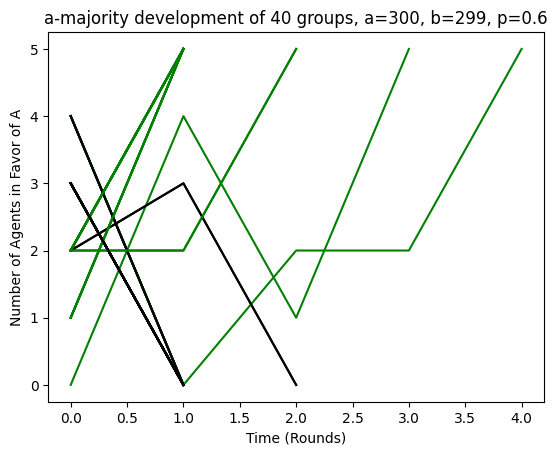

In [ ]:

import matplotlib.pyplot as plt

# Initialize plot
fig, ax = plt.subplots()

# Loop through each array in crowd_deliberations
for i, deliberation in enumerate(crowd_deliberations):
    # Plot the deliberation with a separate line
    if final_votes[i] == 'A':
        ax.plot(range(len(deliberation)), deliberation, color="green")
    else:
      ax.plot(range(len(deliberation)), deliberation, color="black")

# Set labels and title
ax.set_xlabel("Time (Rounds)")
ax.set_ylabel("Number of Agents in Favor of A")

# Add legend and show plot
plt.title("a-majority development of 40 groups, a=300, b=299, p=0.6")
plt.show()


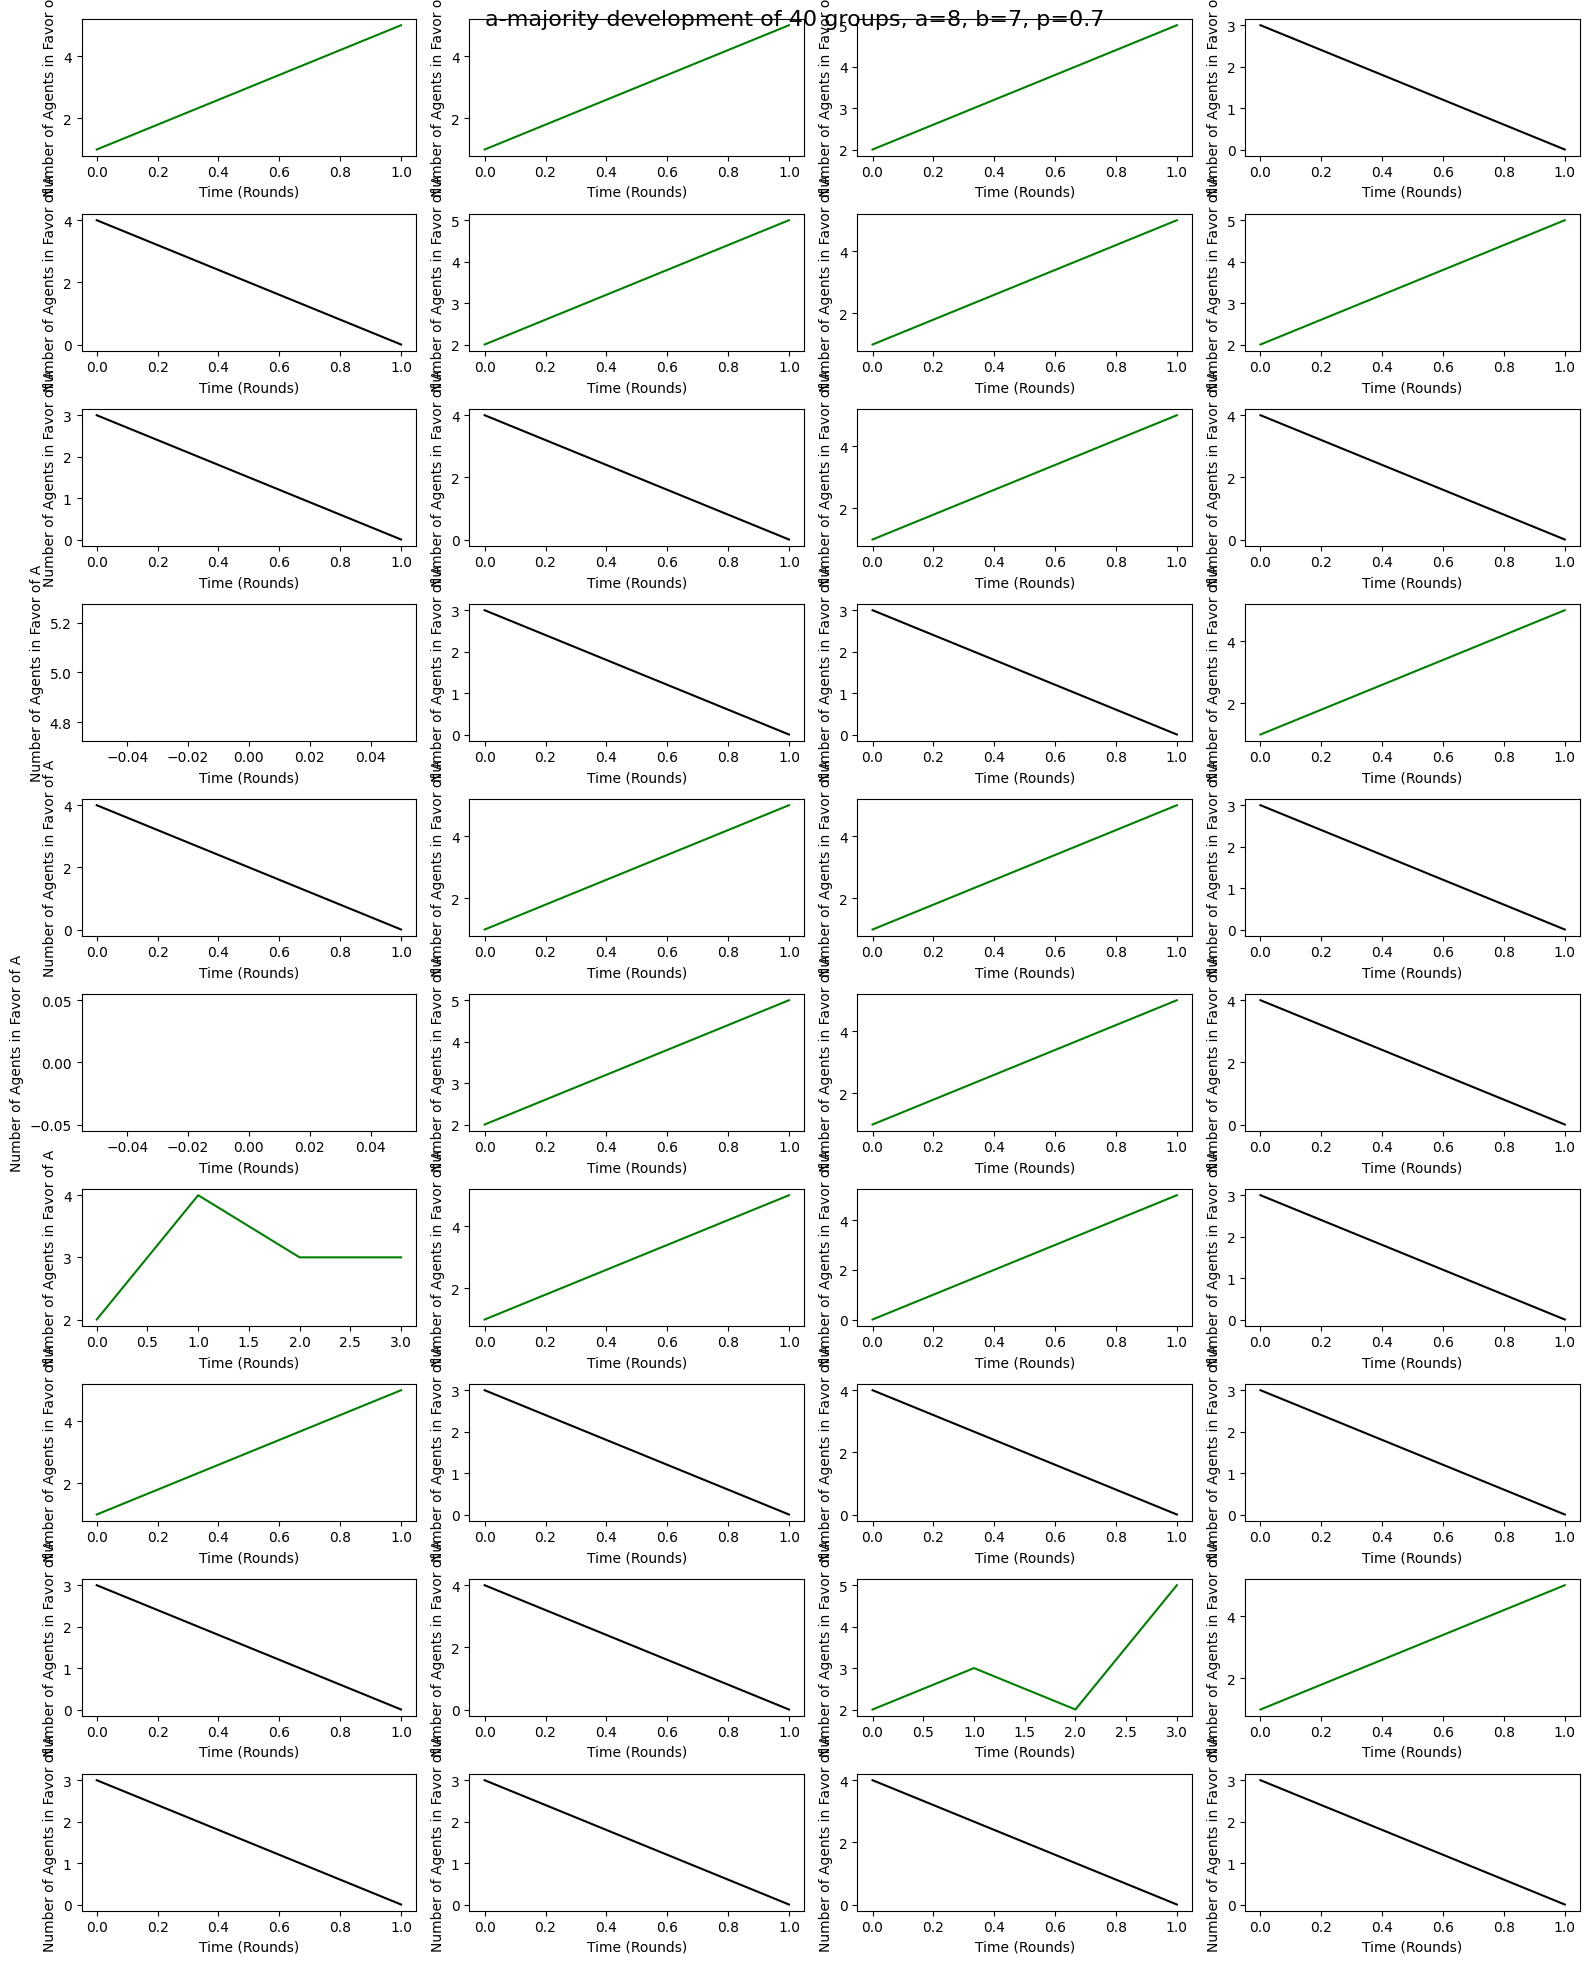

In [ ]:
# prompt: Do the same as in the last block, except that you create subplots for each unique graph

import random as rd
import matplotlib.pyplot as plt
import numpy as np

# ... (preceding code remains the same)

# Initialize plot with subplots
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(16, 20))  # Adjust nrows, ncols as needed

# Loop through each array in crowd_deliberations
for i, deliberation in enumerate(crowd_deliberations):
    row = i // 4
    col = i % 4
    ax = axes[row, col]

    # Plot the deliberation with a separate line
    if final_votes[i] == 'A':
        ax.plot(range(len(deliberation)), deliberation, color="green")
    else:
        ax.plot(range(len(deliberation)), deliberation, color="black")

    # Set labels and title for each subplot
    ax.set_xlabel("Time (Rounds)")
    ax.set_ylabel("Number of Agents in Favor of A")

# Add overall title and adjust layout
fig.suptitle("a-majority development of 40 groups, a=8, b=7, p=0.7", fontsize=16)
plt.tight_layout()
plt.show()


### Sampling

In [ ]:
intial_a_crowds = []
intial_b_crowds = []
initial_x_crowds = []

no_of_agents = [3,5,7,9,11,13,15,17,19]

for number in no_of_agents:

    initial_a = []
    initial_b = [] # Might contain x as well
    initial_x = []

    while len(initial_a) < 4000 or len(initial_b) < 4000:
        crowd = CrowdWithVoteRecord(no_of_agents=number)

        winner, record = crowd.deliberate_sim()

        if record[0] > number//2 and len(initial_a)<4000:
            initial_a.append(winner)
        elif record[0] <= number//2 and len(initial_b)<4000:
          initial_b.append(winner)
        elif record[0] > number//2 and len(initial_a)>=4000:
          pass
        elif record[0] <= number//2 and len(initial_b)<4000:
          pass
        else:
          pass

    print(len(initial_a), len(initial_b), len(initial_x))
    intial_a_crowds.append(initial_a)
    intial_b_crowds.append(initial_b)
    initial_x_crowds.append(initial_x)

Streaming output truncated to the last 5000 lines.
Evidence A: ██▒
Evidence B: █▒
19
Evidence A: █▒▒
Evidence B: ▒▒
_______________WINNER A.______________
Termination at round 2: No more dissenters.
['A', 'X', 'A', 'A', 'B', 'X', 'A', 'B', 'A', 'X', 'X', 'A', 'A', 'B', 'X', 'X', 'A', 'A', 'X']
First dissenters: [None, 'B', None, None, 'B', 'B', None, 'B', None, 'B', 'B', None, None, 'B', 'B', 'B', None, None, 'B']
First majority vote: A

Agent 1 s dissenter_evidence for the minority B:  [1, 1]
Revealing new evidence 0 for minority option B from agent 1
Revealing new evidence 1 for minority option B from agent 1
Agent 4 s dissenter_evidence for the minority B:  [1, 1]
Agent 5 s dissenter_evidence for the minority B:  [1, 1]
Agent 7 s dissenter_evidence for the minority B:  [1, 1]
Agent 9 s dissenter_evidence for the minority B:  [0, 1]
Agent 10 s dissenter_evidence for the minority B:  [1, 0]
Agent 13 s dissenter_evidence for the minority B:  [1, 1]
Agent 14 s dissenter_evidence for the

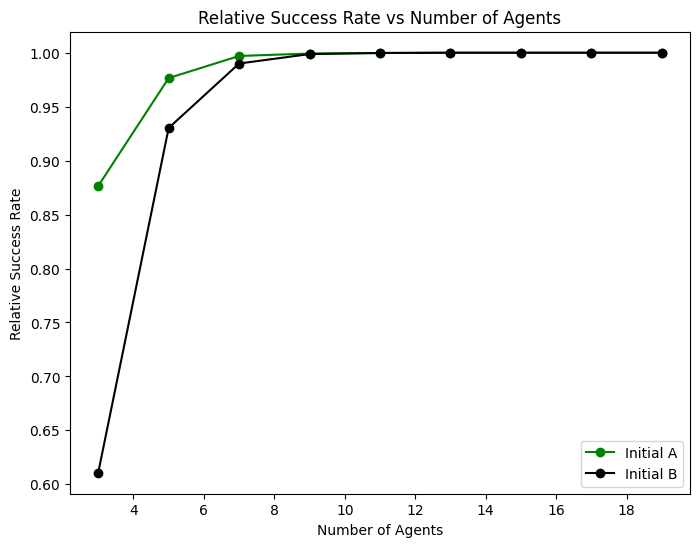

In [ ]:
#For all initial_a calculate the relative success rate (relative frequency of a's), and plot it on the y axis, with the number of agents on the x axis. Do the same for initial_b s with a different line color in the same graph

# Calculate the relative success rate for initial_a and initial_b
success_rate_a = []
success_rate_b = []
for i in range(len(no_of_agents)):
  success_rate_a.append(intial_a_crowds[i].count('A') / len(intial_a_crowds[i]))
  success_rate_b.append(intial_b_crowds[i].count('A') / len(intial_b_crowds[i]))

# Plot the success rates
plt.figure(figsize=(8, 6))
plt.plot(no_of_agents, success_rate_a, marker='o', color='green', label='Initial A')
plt.plot(no_of_agents, success_rate_b, marker='o', color='black', label='Initial B')

# Set labels and title
plt.xlabel("Number of Agents")
plt.ylabel("Relative Success Rate")
plt.title("Relative Success Rate vs Number of Agents")
plt.legend()
plt.show()


In [ ]:
intial_a_crowds = []
intial_b_crowds = []
initial_x_crowds = []

no_of_agents = [3,5,7,9,11,13,15,17,19]

for number in no_of_agents:

    initial_a2 = []
    initial_b2 = [] # Might contain x as well
    initial_x2 = []

    while len(initial_a2) < 2000 or len(initial_b2) < 2000:
        crowd = CrowdWithVoteRecord(no_of_agents=number)

        winner, record = crowd.deliberate_sim()

        if record[0] > number//2 and len(initial_a2)<2000 and len(record)> 1:
            initial_a2.append(winner)
        elif record[0] <= number//2 and len(initial_b2)<2000 and len(record)>1:
          initial_b2.append(winner)
        else:
          pass

    print(len(initial_a2), len(initial_b2), len(initial_x2))
    intial_a_crowds.append(initial_a2)
    intial_b_crowds.append(initial_b2)
    initial_x_crowds.append(initial_x2)

Streaming output truncated to the last 5000 lines.
Evidence A: █▒▒
Evidence B: █▒
12
Evidence A: ███
Evidence B: █▒
13
Evidence A: █▒▒
Evidence B: ██
14
Evidence A: ███
Evidence B: █▒
15
Evidence A: █▒▒
Evidence B: █▒
16
Evidence A: ▒▒▒
Evidence B: █▒
17
Evidence A: ██▒
Evidence B: ██
18
Evidence A: ███
Evidence B: ██
19
Evidence A: ███
Evidence B: █▒
_______________WINNER A.______________
Termination at round 2: No more dissenters.
['A', 'A', 'X', 'B', 'A', 'A', 'B', 'A', 'B', 'X', 'B', 'X', 'X', 'X', 'A', 'A', 'B', 'A', 'X']
First dissenters: [None, None, 'B', 'B', None, None, 'B', None, 'B', 'B', 'B', 'B', 'B', 'B', None, None, 'B', None, 'B']
First majority vote: A

Agent 2 s dissenter_evidence for the minority B:  [1, 0]
Revealing new evidence 0 for minority option B from agent 2
Agent 3 s dissenter_evidence for the minority B:  [1, 0]
Agent 6 s dissenter_evidence for the minority B:  [1, 1]
Revealing new evidence 1 for minority option B from agent 6
Agent 8 s dissenter_evidence f

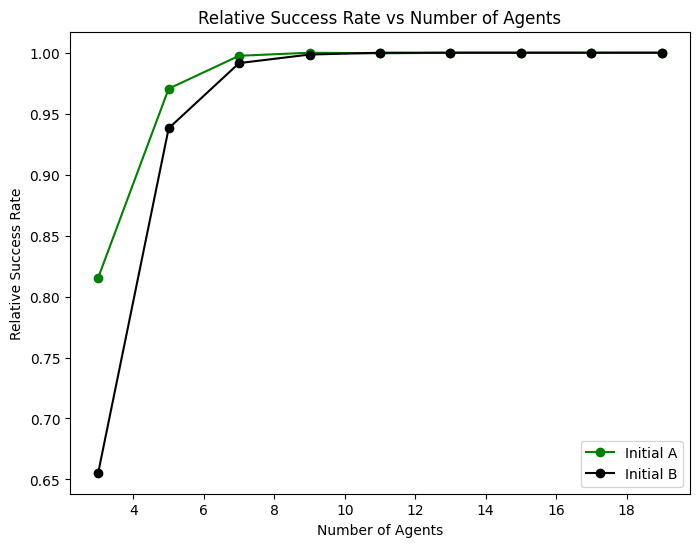

In [ ]:
#For all initial_a calculate the relative success rate (relative frequency of a's), and plot it on the y axis, with the number of agents on the x axis. Do the same for initial_b s with a different line color in the same graph

# Calculate the relative success rate for initial_a and initial_b
success_rate_a = []
success_rate_b = []
for i in range(len(no_of_agents)):
  success_rate_a.append(intial_a_crowds[i].count('A') / len(intial_a_crowds[i]))
  success_rate_b.append(intial_b_crowds[i].count('A') / len(intial_b_crowds[i]))

# Plot the success rates
plt.figure(figsize=(8, 6))
plt.plot(no_of_agents, success_rate_a, marker='o', color='green', label='Initial A')
plt.plot(no_of_agents, success_rate_b, marker='o', color='black', label='Initial B')

# Set labels and title
plt.xlabel("Number of Agents")
plt.ylabel("Relative Success Rate")
plt.title("Relative Success Rate vs Number of Agents")
plt.legend()
plt.show()